# Milestone

This is the code for the project: 

*From RoBERTa to aLEXa: the Gold Standard for **A**utomated **L**egal **Ex**pert **A**rbitrators*.

## 0. Background

In [1]:
ARTICLES = {
    "2": "Right to life",
    "3": "Prohibition of torture",
    "4": "Prohibition of slavery and forced labour",
    "5": "Right to liberty and security",
    "6": "Right to a fair trial",
    "7": "No punishment without law",
    "8": "Right to respect for private and family life",
    "9": "Freedom of thought, conscience and religion",
    "10": "Freedom of expression",
    "11": "Freedom of assembly and association",
    "12": "Right to marry",
    "13": "Right to an effective remedy",
    "14": "Prohibition of discrimination",
    "15": "Derogation in time of emergency",
    "16": "Restrictions on political activity of aliens",
    "17": "Prohibition of abuse of rights",
    "18": "Limitation on use of restrictions on rights",
    "34": "Individual applications",
    "38": "Examination of the case",
    "39": "Friendly settlements",
    "46": "Binding force and execution of judgments",
    "P1-1": "Protection of property",
    "P1-2": "Right to education",
    "P1-3": "Right to free elections",
    "P3-1": "Right to free elections",
    "P4-1": "Prohibition of imprisonment for debt",
    "P4-2": "Freedom of movement",
    "P4-3": "Prohibition of expulsion of nationals",
    "P4-4": "Prohibition of collective expulsion of aliens",
    "P6-1": "Abolition of the death penalty",
    "P6-2": "Death penalty in time of war",
    "P6-3": "Prohibition of derogations",
    "P7-1": "Procedural safeguards relating to expulsion of aliens",
    "P7-2": "Right of appeal in criminal matters",
    "P7-3": "Compensation for wrongful conviction",
    "P7-4": "Right not to be tried or punished twice",
    "P7-5": "Equality between spouses",
    "P12-1": "General prohibition of discrimination",
    "P13-1": "Abolition of the death penalty",
    "P13-2": "Prohibition of derogations",
    "P13-3": "Prohibition of reservations",
}

## 1. Installations & Imports

### 1.1 Installations

In [2]:
!pip install tqdm
!pip install transformers
!pip install datasets

### 1.2 Imports

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from tqdm import tqdm

### 1.3 Initialization

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)

## 2. ECHR Dataset (2019)

In [6]:
!unzip ECHR_Dataset.zip

Archive:  ECHR_Dataset.zip
replace __MACOSX/._ECHR_Dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
import os
import json
from glob import glob
from datasets import Dataset

In [8]:
def process_echr_dataset(path):
  all_files = glob(os.path.join(path, "*.json"))
  data = {
      'facts': [],
      'articles': [],
      'labels': [],
      'ids': []
  }

  for filename in tqdm(all_files):
    with open(filename) as f:
      case_data = json.load(f)

    data['facts'].append(case_data['TEXT'])
    data['articles'].append(case_data['VIOLATED_ARTICLES'])
    data['labels'].append(int(len(case_data['VIOLATED_ARTICLES']) > 0))
    data['ids'].append(case_data['ITEMID'])

  df = pd.DataFrame.from_dict(data)
  custom_dataset = Dataset.from_pandas(df)
  return custom_dataset

In [9]:
def generate_echr_dataset(shuffle=True, n_subset=None, seed=1111):
    train = process_echr_dataset('ECHR_Dataset/EN_train')
    val = process_echr_dataset('ECHR_Dataset/EN_dev')
    test = process_echr_dataset('ECHR_Dataset/EN_test')
    splits = [train, val, test]
    print(train)

    if train.num_rows == 0:
      raise Exception('Dataset is empty.')

    if shuffle:
      splits = [x.shuffle(seed=seed) for x in splits]

    if n_subset:
      splits = [x.select(range(n_subset)) for x in splits]

    echr_dataset = DatasetDict(
        train=splits[0],
        val=splits[1],
        test=splits[2]
    )
    return echr_dataset

In [10]:
echr_dataset = generate_echr_dataset(n_subset=64)

100%|██████████| 2998/2998 [00:01<00:00, 2131.20it/s]


Dataset({
    features: ['facts', 'articles', 'labels', 'ids'],
    num_rows: 7100
})


In [11]:
echr_dataset

DatasetDict({
    train: Dataset({
        features: ['facts', 'articles', 'labels', 'ids'],
        num_rows: 64
    })
    val: Dataset({
        features: ['facts', 'articles', 'labels', 'ids'],
        num_rows: 64
    })
    test: Dataset({
        features: ['facts', 'articles', 'labels', 'ids'],
        num_rows: 64
    })
})

In [12]:
#echr_dataset['train'][0]

## ECTHR Dataset from Local File (2021)

In [ ]:
!unzip ECTHR_Dataset.zip

Archive:  ECTHR_Dataset.zip
  inflating: dev.jsonl               
  inflating: test.jsonl              
  inflating: train.jsonl             


In [ ]:
def generate_ecthr_dataset(file):
  data = {
      'facts': [],
      'articles': [],
      'labels': [],
      'ids': [],
      'rationale': [],
      'rationale_detail': []
  }

  with open(file, 'r') as json_file:
    json_list = list(json_file)

  for json_str in tqdm(json_list):
    case_data = json.loads(json_str)

    data['facts'].append(case_data['facts'])
    data['articles'].append(case_data['violated_articles'])
    data['labels'].append(int(len(case_data['violated_articles']) > 0))
    data['rationale'].append(case_data['silver_rationales'])
    data['rationale_detail'].append(case_data['court_assessment_references'])
    data['ids'].append(case_data['case_id'])

  df = pd.DataFrame.from_dict(data)
  custom_dataset = Dataset.from_pandas(df)
  return custom_dataset

In [ ]:
ecthr_dataset = DatasetDict(
    train=generate_ecthr_dataset('train.jsonl'),
    val=generate_ecthr_dataset('dev.jsonl'),
    test=generate_ecthr_dataset('test.jsonl')
)

100%|██████████| 1000/1000 [00:00<00:00, 14035.00it/s]


In [ ]:
ecthr_dataset

DatasetDict({
    train: Dataset({
        features: ['facts', 'articles', 'labels', 'ids', 'rationale', 'rationale_detail'],
        num_rows: 9000
    })
    val: Dataset({
        features: ['facts', 'articles', 'labels', 'ids', 'rationale', 'rationale_detail'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['facts', 'articles', 'labels', 'ids', 'rationale', 'rationale_detail'],
        num_rows: 1000
    })
})

In [ ]:
def search_in_dataset(case_id):
    for j, case_new in enumerate(ecthr_dataset['train']):
      if case_id == case_new['ids']:
        print(f'Case {id} found in case: train', j)
        return 'train', j

    for j, case_new in enumerate(ecthr_dataset['val']):
      if id == case_new['ids']:
        print(f'Case {id} found in case: val', j)
        return 'val', j

    for j, case_new in enumerate(ecthr_dataset['val']):
      if id == case_new['ids']:
        print(f'Case {id} found in case: test', j)
        return 'test', j

    return None

match_dict = {}

for i, case in enumerate(echr_dataset['train']):
  id = case['ids']
  return_tuple = search_in_dataset(id)
  if not return_tuple:
    print(f'Case {id} not found. Label:', case['labels'])
  match_dict[id] = return_tuple

Case 001-77871 not found. Label: 0
Case 001-84329 found in case: train 3267
Case 001-111044 found in case: train 6823
Case 001-97299 found in case: train 5077
Case 001-24068 not found. Label: 0
Case 001-105236 found in case: train 6185
Case 001-82671 not found. Label: 0
Case 001-73367 found in case: train 1788
Case 001-85631 not found. Label: 0
Case 001-88572 not found. Label: 0
Case 001-60457 found in case: train 105
Case 001-89271 found in case: train 3881
Case 001-86524 not found. Label: 0
Case 001-114939 found in case: train 7205
Case 001-119272 not found. Label: 0
Case 001-100198 found in case: train 5493
Case 001-60172 found in case: train 76
Case 001-57985 not found. Label: 1
Case 001-23252 not found. Label: 0
Case 001-105217 found in case: train 6180
Case 001-23267 not found. Label: 0
Case 001-75994 not found. Label: 0
Case 001-100801 not found. Label: 0
Case 001-69831 found in case: train 1239
Case 001-128050 found in case: train 7763
Case 001-70767 found in case: train 1382
C

KeyboardInterrupt: ignored

In [ ]:
sorted(echr_dataset['train']['ids'])

['001-100005',
 '001-100024',
 '001-100026',
 '001-100029',
 '001-100038',
 '001-100042',
 '001-100083',
 '001-100092',
 '001-100093',
 '001-100095',
 '001-100099',
 '001-100105',
 '001-100133',
 '001-100135',
 '001-100181',
 '001-100182',
 '001-100190',
 '001-100195',
 '001-100198',
 '001-100212',
 '001-100250',
 '001-100265',
 '001-100269',
 '001-100271',
 '001-100281',
 '001-100287',
 '001-100293',
 '001-100300',
 '001-100307',
 '001-100309',
 '001-100362',
 '001-100377',
 '001-100379',
 '001-100387',
 '001-100389',
 '001-100393',
 '001-100395',
 '001-100404',
 '001-100407',
 '001-100409',
 '001-100411',
 '001-100413',
 '001-100424',
 '001-100440',
 '001-100442',
 '001-100461',
 '001-100470',
 '001-100472',
 '001-100483',
 '001-100492',
 '001-100500',
 '001-100504',
 '001-100506',
 '001-100508',
 '001-100517',
 '001-100520',
 '001-100527',
 '001-100548',
 '001-100559',
 '001-100576',
 '001-100578',
 '001-100657',
 '001-100659',
 '001-100661',
 '001-100665',
 '001-100666',
 '001-1006

In [ ]:
ecthr_dataset['train']['ids']

['001-59587',
 '001-59591',
 '001-59590',
 '001-59588',
 '001-59589',
 '001-59603',
 '001-59594',
 '001-59592',
 '001-59604',
 '001-59608',
 '001-59607',
 '001-59605',
 '001-59614',
 '001-59616',
 '001-59613',
 '001-59622',
 '001-59626',
 '001-59625',
 '001-59621',
 '001-59666',
 '001-59665',
 '001-59667',
 '001-59682',
 '001-59690',
 '001-59689',
 '001-59692',
 '001-59703',
 '001-59714',
 '001-59713',
 '001-59722',
 '001-59721',
 '001-59720',
 '001-59865',
 '001-59860',
 '001-59868',
 '001-59869',
 '001-59873',
 '001-59876',
 '001-59880',
 '001-59884',
 '001-59881',
 '001-59886',
 '001-59887',
 '001-59885',
 '001-59931',
 '001-59984',
 '001-59985',
 '001-59983',
 '001-59987',
 '001-59992',
 '001-59999',
 '001-59998',
 '001-59997',
 '001-60000',
 '001-59996',
 '001-60001',
 '001-60005',
 '001-60014',
 '001-60016',
 '001-60329',
 '001-60019',
 '001-60021',
 '001-60024',
 '001-60026',
 '001-60035',
 '001-60112',
 '001-60156',
 '001-60158',
 '001-60157',
 '001-60169',
 '001-60163',
 '001-

## 3. ECtHR Dataset (2021)

In [ ]:
ecthr_data = load_dataset('ecthr_cases', 'violation-prediction')

Reusing dataset ecthr_cases (/root/.cache/huggingface/datasets/ecthr_cases/violation-prediction/1.1.0/8922a012792758e64921d4a66d42adf759e42838aae54a6a8871607f6399aecf)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ecthr_data

DatasetDict({
    train: Dataset({
        features: ['facts', 'labels', 'silver_rationales'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['facts', 'labels', 'silver_rationales'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['facts', 'labels', 'silver_rationales'],
        num_rows: 1000
    })
})

In [ ]:
ecthr_data['train'].__dict__

{'_data': MemoryMappedTable
 facts: list<item: string>
   child 0, item: string
 labels: list<item: string>
   child 0, item: string
 silver_rationales: list<item: int32>
   child 0, item: int32
 ----
 facts: [[["11.  At the beginning of the events relevant to the application, K. had a daughter, P., and a son, M., born in 1986 and 1988 respectively. P.’s father is X and M.’s father is V. From March to May 1989 K. was voluntarily hospitalised for about three months, having been diagnosed as suffering from schizophrenia. From August to November 1989 and from December 1989 to March 1990, she was again hospitalised for periods of about three months on account of this illness. In 1991 she was hospitalised for less than a week, diagnosed as suffering from an atypical and undefinable psychosis. It appears that social welfare and health authorities have been in contact with the family since 1989.","12.  The applicants initially cohabited from the summer of 1991 to July 1993. In 1991 both P. an

In [ ]:
ecthr_train, ecthr_val, ecthr_test = echr_data['train'], echr_data['validation'], ecthr_data['test']

NameError: ignored

In [ ]:
ecthr_train

Dataset({
    features: ['facts', 'labels', 'silver_rationales'],
    num_rows: 9000
})

In [ ]:
ecthr_train['facts'][1100]

['7.  The applicant is a Polish national who was born in 1950 and lives in Wodzisław.',
 '8.  In October 1995 a local branch of the Christian-National Association published a political leaflet entitled “Wodzisławianin”, which contained a following note, written by the applicant:\n“The inhabitants of Wodzisław wonder why the lists of the local election commissions [for the coming 1995 presidential election] have not been made public in the city hall, as used to be the case.\nWe have the answer to this question: the composition of nine election committees was determined in a secret vote held by the [Wodzisław] Municipal Council, and the councillors elected themselves to hold posts [in these commissions]. Sixteen persons [who were not members of the Council] were not elected, including four representatives of the lower councils, three women [...] who are all respectable citizens.\nThe payment for the work in the election commission is PLZ 1,500,000, which is equivalent to two thirds of [u

## Data Exploration

In [97]:
echr_dataset

DatasetDict({
    train: Dataset({
        features: ['facts', 'articles', 'labels', 'ids'],
        num_rows: 64
    })
    val: Dataset({
        features: ['facts', 'articles', 'labels', 'ids'],
        num_rows: 64
    })
    test: Dataset({
        features: ['facts', 'articles', 'labels', 'ids'],
        num_rows: 64
    })
})

There are 9k cases in the training set. Each element in the training set is a list of paragraphs.

In [ ]:
paras_per_case = sorted([len(x) for x in ecthr_train['facts']], reverse=True)
pd.Series(paras_per_case).describe()

count    9000.000000
mean       23.653111
std        22.783898
min         1.000000
25%        10.000000
50%        17.000000
75%        29.000000
max       558.000000
dtype: float64

In [ ]:
all_train_paras = [paragraph for case in ecthr_train['facts'] for paragraph in case]
words_per_para = sorted([len(x.split()) for x in all_train_paras], reverse=True)
pd.Series(words_per_para).describe()

count    212878.00000
mean         68.45768
std          98.60012
min           4.00000
25%          27.00000
50%          46.00000
75%          80.00000
max        8971.00000
dtype: float64

In [ ]:
words_per_para = sorted([len(x.split('.')) for x in all_train_paras], reverse=True)
pd.Series(words_per_para).describe()

count    212878.000000
mean          5.814988
std           7.235706
min           2.000000
25%           3.000000
50%           4.000000
75%           6.000000
max         790.000000
dtype: float64

Summary statistics:

(0.0, 300.0)

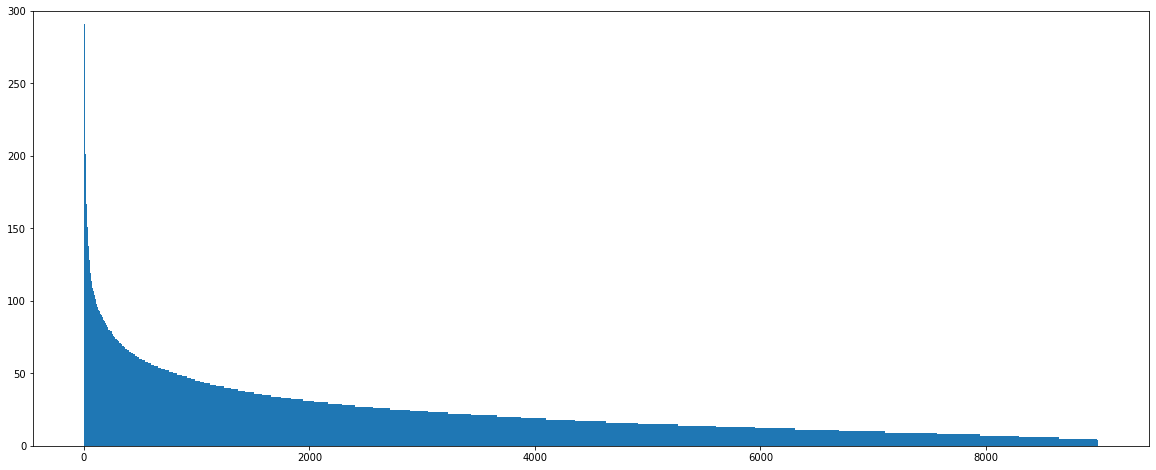

In [ ]:
plt.bar(list(range(ecthr_train.num_rows)), paras_per_case, width=1.0)
plt.ylim(0, 300)

In [13]:
len(set([label for labels in echr_dataset['train']['articles'] for label in labels]))

11

In [14]:
train_labels = sorted(list(set([label for labels in echr_dataset['train']['articles'] for label in labels])))
train_labels

['11', '13', '14', '2', '3', '38', '5', '6', '8', '9', 'P1']

In [15]:
val_labels = sorted(list(set([label for labels in echr_dataset['val']['articles'] for label in labels])))
val_labels

['13', '2', '3', '34', '5', '6', '8', 'P1']

In [16]:
sorted_labels = sorted([int(x) if 'P' not in x else x for x in train_labels][:-3]) + train_labels[-3:]
sorted_labels = [str(x) for x in sorted_labels]

In [17]:
sorted_labels = sorted(train_labels + val_labels)
sorted_labels

['11',
 '13',
 '13',
 '14',
 '2',
 '2',
 '3',
 '3',
 '34',
 '38',
 '5',
 '5',
 '6',
 '6',
 '8',
 '8',
 '9',
 'P1',
 'P1']

In [18]:
one_hot_mapping = {x: i for i, x in enumerate(sorted_labels)}
one_hot_mapping

{'11': 0,
 '13': 2,
 '14': 3,
 '2': 5,
 '3': 7,
 '34': 8,
 '38': 9,
 '5': 11,
 '6': 13,
 '8': 15,
 '9': 16,
 'P1': 18}

## 4. Baselines

### 4.1 Baselines Chalkidis et al. (2019)

#### 4.1.1 BERT Baseline

*For a new task, a task-specific layer is added on top of BERT and is trained jointly by fine-tuning on task-specific data. We add a linear layer on top of BERT, with a sigmoid [or] softmax [...] for binary violation [or] multi-label violation, [...] respectively. BERT can process texts up to 512 wordpieces, whereas our case descriptions are up to 2.6k words, thus we truncate them to BERT’s maximum length, which affects its performance.*

**Truncating**

In [19]:
def to_one_hot(labels, n_categories=len(sorted_labels)):
  indices = [one_hot_mapping[y] for y in labels]
  one_hots = np.zeros(n_categories)
  one_hots[indices] = 1
  return torch.Tensor(one_hots)

def to_bert(example):
  return {
    'text': ' '.join(example['facts']),
    'labels': example['labels'],
    'articles': to_one_hot(example['articles'])
  }

In [20]:
bert_train, bert_val = echr_dataset['train'].map(to_bert), echr_dataset['val'].map(to_bert)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [21]:
bert_train = bert_train.remove_columns(['facts']) #, 'silver_rationales'])
bert_val = bert_val.remove_columns(['facts']) #, 'silver_rationales'])

In [22]:
bert_train

Dataset({
    features: ['articles', 'labels', 'ids', 'text'],
    num_rows: 64
})

In [23]:
pos = 0
for l in bert_train['labels']:
  if l == 1:
    pos += 1

print(pos / len(bert_train['labels']))

0.484375


**Preprocessing**

In [24]:
from transformers import AutoTokenizer

In [25]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [26]:
bert_train = bert_train.map(
               lambda example: tokenizer(example['text'], padding=True, truncation=True, max_length=512),
               batched=True,
               batch_size=16
             )

  0%|          | 0/4 [00:00<?, ?ba/s]

In [27]:
bert_val = bert_val.map(
               lambda example: tokenizer(example['text'], padding=True, truncation=True, max_length=512),
               batched=True,
               batch_size=16
           )

  0%|          | 0/4 [00:00<?, ?ba/s]

In [28]:
bert_train.set_format('torch')
bert_val.set_format('torch')

**Saving Tokens**

In [29]:
torch.save(bert_train, 'bert_train_tokenized')

In [30]:
torch.save(bert_val, 'bert_val_tokenized')

In [ ]:
bert_train = torch.load('bert_train_tokenized')

In [ ]:
bert_val = torch.load('bert_val_tokenized')

In [83]:
bert_train

Dataset({
    features: ['articles', 'labels', 'ids', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 256
})

In [ ]:
#bert_train = bert_train.rename_column('labels', 'multi-labels')
#bert_train = bert_train.rename_column('label', 'labels')

#bert_val = bert_val.rename_column('labels', 'multi-labels')
#bert_val = bert_val.rename_column('label', 'labels')

In [31]:
bert_train = bert_train.remove_columns(['text', 'articles', 'ids'])
bert_val = bert_val.remove_columns(['text', 'articles', 'ids'])

In [32]:
bert_train

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 64
})

In [33]:
bert_val

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 64
})

**Training**

In [34]:
from torch.utils.data import DataLoader

#train_dataloader = DataLoader(bert_train, batch_size=16)
#eval_dataloader = DataLoader(bert_val, batch_size=16)

In [55]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

In [60]:
from transformers import TrainingArguments, Trainer

arguments = TrainingArguments(
    output_dir='bert_trainer',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    evaluation_strategy='epoch', # run validation at the end of each epoch
    save_strategy='epoch',
    learning_rate=2e-5, # 1e-3
    logging_steps=1,
    load_best_model_at_end=True,
    seed=224
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    print(predictions)
    eval_dict = {
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions)
    }
    return eval_dict

In [62]:
trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=bert_train,
    eval_dataset=bert_val, # change to test when you do your final evaluation!
    #tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [59]:
import json
from transformers import TrainerCallback, EarlyStoppingCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop('total_flos', None)
        if state.is_local_process_zero:
            with open(self.log_path, 'a') as f:
                f.write(json.dumps(logs) + '\n')


trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback('bert_trainer/log.jsonl'))

In [63]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 64
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 80


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.648400,0.656103,0.909091,0.666667,0.769231
2,0.824600,0.636084,0.545455,1.000000,0.705882
3,0.631100,0.510947,0.852941,0.966667,0.906250
4,0.527600,0.441234,0.828571,0.966667,0.892308
5,0.634300,0.390361,0.810811,1.000000,0.895522
6,0.291600,0.331501,0.875000,0.933333,0.903226
7,0.272900,0.292904,0.882353,1.000000,0.937500
8,0.254700,0.267039,0.882353,1.000000,0.937500
9,0.271100,0.266470,0.896552,0.866667,0.881356
10,0.130800,0.248125,0.875000,0.933333,0.903226


***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1]


Saving model checkpoint to bert_trainer/checkpoint-8
Configuration saved in bert_trainer/checkpoint-8/config.json
Model weights saved in bert_trainer/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


Saving model checkpoint to bert_trainer/checkpoint-16
Configuration saved in bert_trainer/checkpoint-16/config.json
Model weights saved in bert_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1]


Saving model checkpoint to bert_trainer/checkpoint-24
Configuration saved in bert_trainer/checkpoint-24/config.json
Model weights saved in bert_trainer/checkpoint-24/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1]


Saving model checkpoint to bert_trainer/checkpoint-32
Configuration saved in bert_trainer/checkpoint-32/config.json
Model weights saved in bert_trainer/checkpoint-32/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1]


Saving model checkpoint to bert_trainer/checkpoint-40
Configuration saved in bert_trainer/checkpoint-40/config.json
Model weights saved in bert_trainer/checkpoint-40/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1]


Saving model checkpoint to bert_trainer/checkpoint-48
Configuration saved in bert_trainer/checkpoint-48/config.json
Model weights saved in bert_trainer/checkpoint-48/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1]


Saving model checkpoint to bert_trainer/checkpoint-56
Configuration saved in bert_trainer/checkpoint-56/config.json
Model weights saved in bert_trainer/checkpoint-56/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1]


Saving model checkpoint to bert_trainer/checkpoint-64
Configuration saved in bert_trainer/checkpoint-64/config.json
Model weights saved in bert_trainer/checkpoint-64/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1]


Saving model checkpoint to bert_trainer/checkpoint-72
Configuration saved in bert_trainer/checkpoint-72/config.json
Model weights saved in bert_trainer/checkpoint-72/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 64
  Batch size = 8


[0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1
 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1]


Saving model checkpoint to bert_trainer/checkpoint-80
Configuration saved in bert_trainer/checkpoint-80/config.json
Model weights saved in bert_trainer/checkpoint-80/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert_trainer/checkpoint-80 (score: 0.2481253296136856).


TrainOutput(global_step=80, training_loss=0.4227115960791707, metrics={'train_runtime': 255.993, 'train_samples_per_second': 2.5, 'train_steps_per_second': 0.313, 'total_flos': 168391075430400.0, 'train_loss': 0.4227115960791707, 'epoch': 10.0})

In [ ]:
#bert_val = bert_val.remove_columns(['ids'])
model_outputs = model(**bert_val.features)

print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")

In [130]:
!nvidia-smi

Fri Feb 25 07:42:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    64W / 149W |  11429MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [131]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()